# Without sWeights: `common_B0TODst3pi_Dst_constr_BDT-1.25`

# Plot the fit
    
I just want to recreate the figure of the fit to $m(3\pi)$ around $m(D^*)_{PDG}$ with BDT > -1.25, with the colors I cherish.


In [1]:
name_data = 'common_B0TODst3pi_Dst_constr'
name_data_B0toDstDs = 'common_B0TODstDs_Dst_constr'

name_data_Dstto3pi = 'common_DstTO3pi' # same as sWeights as the unconstrained case

name_BDT = 'gradient'

name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"

BDT = -1.25

name_data_BDT = name_data + f'_BDT{BDT}'
name_data_B0toDstDs_BDT = name_data_B0toDstDs + f'_BDT{BDT}'

## Import

In [52]:
import zfit
import json
import numpy as np
import timeit

from numpy.random import normal

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)

from load_save_data import load_saved_root, load_data, add_constr_Dst, json_to_latex_table, retrieve_params, format_previous_params
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import define_zparams, sum_crystalball
from variables import name_params, name_params_KPiPi

import plot.tool as pt

In [3]:
name_params_KPiPi_print = {}
for key, value in name_params_KPiPi.items():
    name_params_KPiPi_print[key+'_Kpipi'] = name_params_KPiPi[key]

## Load

### Json files

In [4]:
name_data_BDT = f"{name_data}_BDT{BDT}"
name_data_B0toDstDs_BDT = f"{name_data_B0toDstDs}_BDT{BDT}"

# Fixed alphaL, alphaR and nL
common_params = retrieve_params(name_data, name_folder=name_data)
# Fixed nR
MC_params = retrieve_params(name_data_MC, name_folder='MC')

# B0->DstKPiPi
Kpipi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV 

# common with BDT cut (for startning values of the fit)
pipipi_params = format_previous_params(retrieve_params(name_data_BDT, name_folder=name_data), True)
# B0->DstDs with BDT cut (for the B0->DstDs PDF shape)
DstDs_params = format_previous_params(retrieve_params(name_data_B0toDstDs_BDT, name_folder=name_data_B0toDstDs), True) 

Load 
- `f_params_dict['1']` - the fixed parameters that will be changed in **mode 1**
- `f_params_dict['2']`  - the fixed parameters that will be changed in **mode 2**

In [5]:
f_params = {} # fixed parameters

for param in 'alphaL', 'alphaR', 'nL', 'r_bkgK':
    f_params[param] = common_params[param] # nominal value

f_params['nR'] = {}
f_params['nR']= MC_params['nR_MC']

for param in 'muL', 'muR', 'nL', 'nR', 'alphaR', 'alphaL', 'sigmaL', 'sigmaR', 'fraction':
    f_params[param+'_Kpipi'] = Kpipi_params[param]


In [39]:
df = load_saved_root('common_'+name_BDT, name_folder='common', vars=['B0_M', 'Dst_M', 'BDT'])
df = df.query(f"BDT > {BDT}")
df = add_constr_Dst(df)

df = df.query(f'{var} > {low} and {var} < {high}')

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient.root


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_cut_-1.25


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.0731)'>)

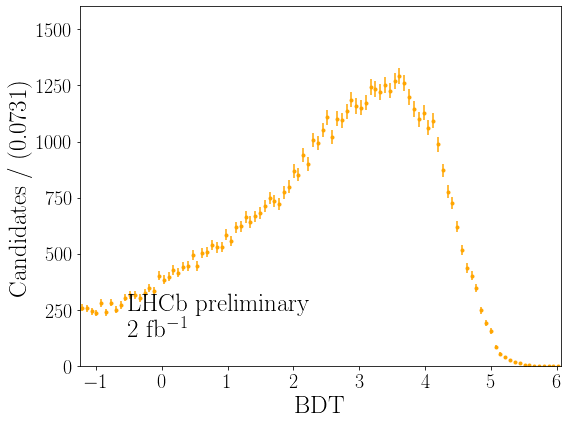

In [40]:
h.plot_hist_particle({'data\_cut\_-1.25': df},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.2,'left'])

## Range of the variables

### Constrained $m(D^* 3\pi)$ of the `common` data

In [41]:
var = 'Dst_constr_B0_M'
low = 5150.
high = 5545.

## PLOT

### Values

In [42]:
initial_values = {
    # Signal        
    'mu'       :{ 'value': pipipi_params['mu']       , 'floating': True},
    'sigmaL'   :{ 'value': pipipi_params['sigmaL']   , 'floating': True},
    'sigmaR'   :{ 'value': pipipi_params['sigmaR']   , 'floating': True},
    'frac'     :{ 'value': pipipi_params['frac']     , 'floating': True},
    'n_sig'    :{ 'value': pipipi_params['n_sig']    , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': pipipi_params['lambda']   , 'floating': True},
    'n_bkg'    :{ 'value': pipipi_params['n_bkg']    , 'floating': True},
    # Background decay D*Kpipi    
}

# Fixed parameters:
for param, value_param in f_params.items():
    initial_values[param] = {}
    initial_values[param]['value'] = value_param
    initial_values[param]['floating'] = False

# B0 -> D* Ds distribution
for vari in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{vari}_Ds'] = {'value': DstDs_params[f'{vari}_DstDs'], 'floating': False}

### Observables and variables

In [10]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])    

### PDFs

In [43]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_Kpipi'], zparams['muR_Kpipi'], 
                                                          zparams['sigmaL_Kpipi'], zparams['sigmaR_Kpipi'],
                                                          zparams['fraction_Kpipi'], obs,
                                                          zparams['alphaL_Kpipi'], zparams['alphaR_Kpipi'], 
                                                          zparams['nL_Kpipi'], zparams['nR_Kpipi'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_Ds_ext = gaussian_Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df[var], obs=obs)

### Plotting

In [44]:
n_events = len(df.query(f"{var} > {low} and {var} < {high}"))

In [45]:
n_bins = int(np.sqrt(n_events))
print(n_bins)

246


Number of bins: 196
Width of the bins: 2.015306122450056

Number of d.o.f. in the model:  7
Reduced chi2:  1.3401697846166696

Mean of the normalised residuals: -0.10044726481054553
Std of the normalised residuals: 1.1323501777344749
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_BDT-1.25_2_fit
Number of bins: 100
Width of the bins: 3.9499999999989086

Number of d.o.f. in the model:  7
Reduced chi2:  1.6278091935282022

Mean of the normalised residuals: -0.08052377047359997
Std of the normalised residuals: 1.2277534249066233
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_BDT-1.25_4_fit
Number of bins: 49
Width of the bins: 8.061224489795677

Number of d.o.f. in the model:  7
Reduced chi2:  1.986706956328036

Mean of the normalised residuals: 0.005657709676238791
Std of the normalised residuals: 1.3049366525520776
/afs/cern.ch/user

(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (8.06 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=1.99)', ylabel='residuals / $\\sigma$'>)

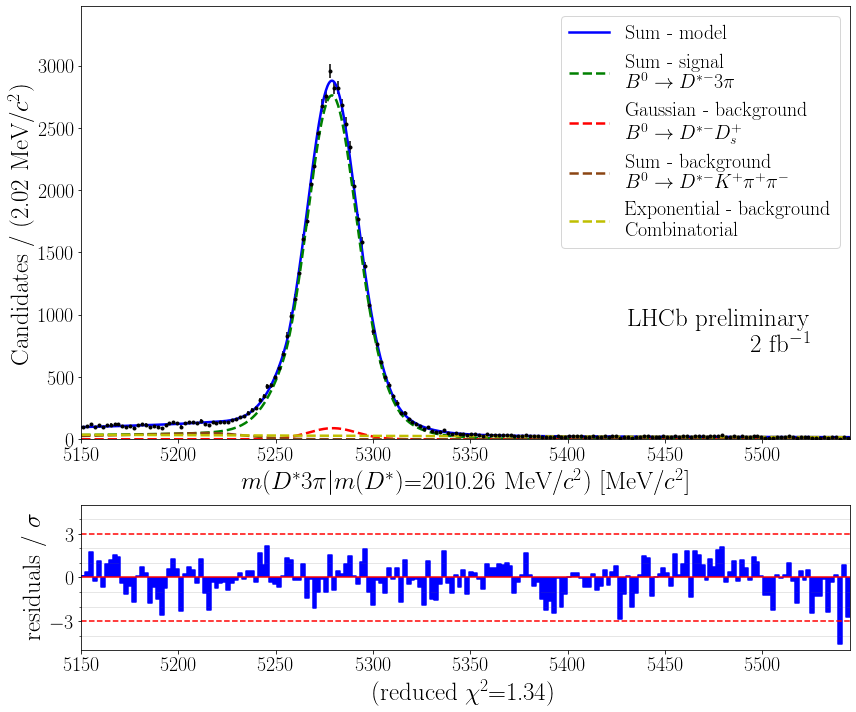

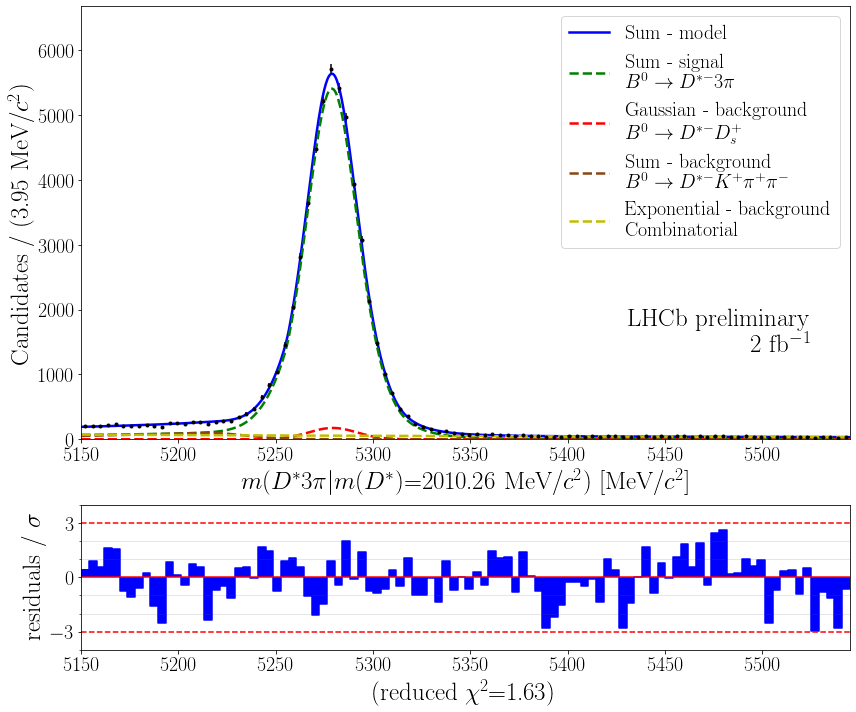

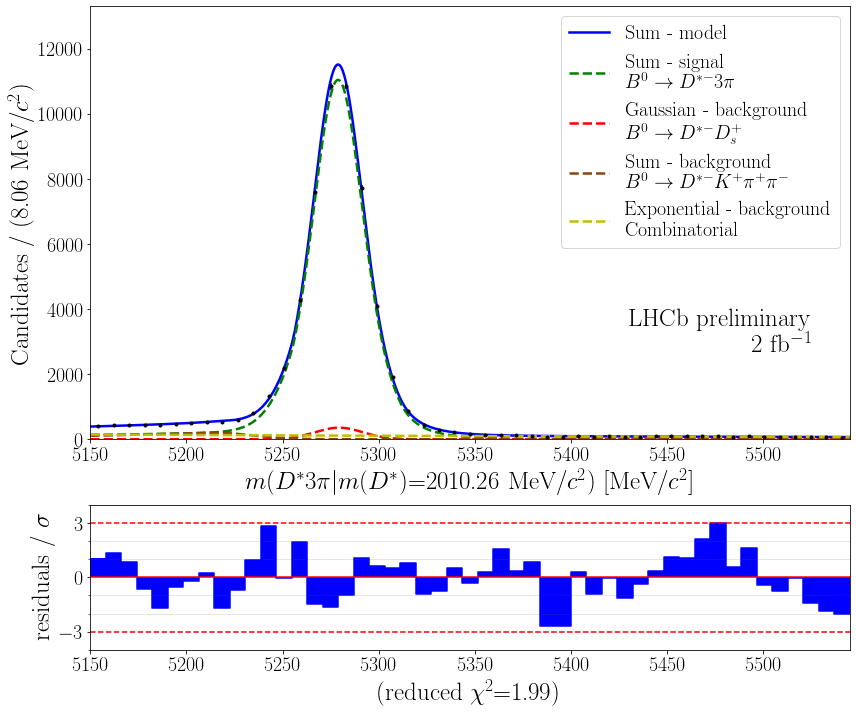

In [46]:
bin_width = 2
n_bins = np.rint(np.round(high-low)/bin_width-1).astype(int)

name_data_plot = name_data + f'_BDT{BDT}_{bin_width}'
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins=n_bins,mode_hist = False, show_chi2=True,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )
bin_width = 4
n_bins = np.rint(np.round(high-low)/bin_width).astype(int)
n_bins = 100
name_data_plot = name_data + f'_BDT{BDT}_{bin_width}'
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins=n_bins,mode_hist = False, show_chi2=True,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )
bin_width = 8
n_bins = np.rint(np.round(high-low)/bin_width).astype(int)

name_data_plot = name_data + f'_BDT{BDT}_{bin_width}'
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins=n_bins,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data, show_chi2=True,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

Number of bins: 33
Width of the bins: 11.969696969697907

Number of d.o.f. in the model:  7
Reduced chi2:  4.457416093709027

Mean of the normalised residuals: 0.12406390909255172
Std of the normalised residuals: 1.8698961830656655
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_33_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (12 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

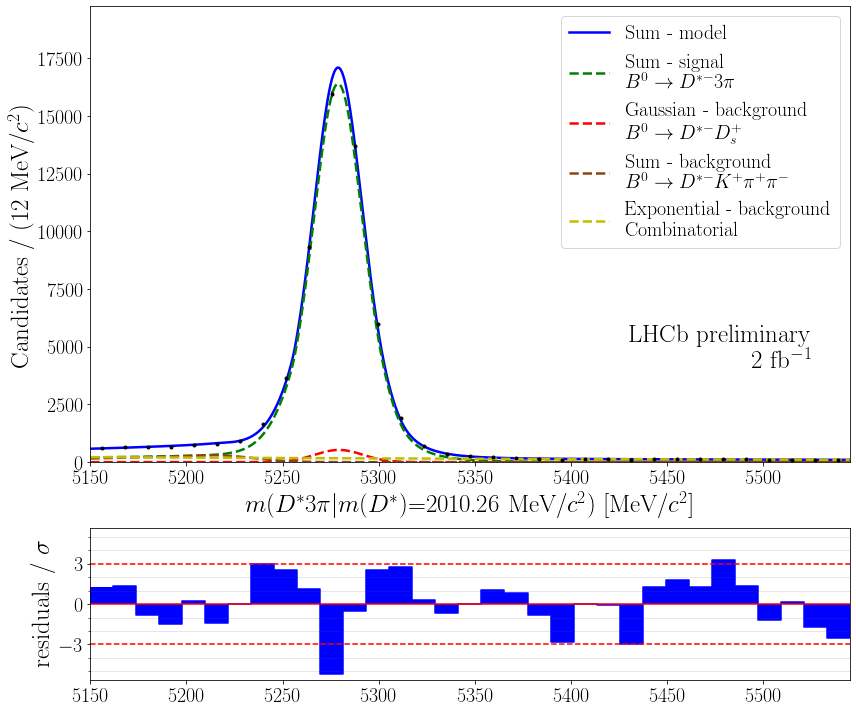

In [15]:
bin_width = 12
n_bins = np.rint(np.round(high-low)/bin_width).astype(int)
name_data_plot = name_data + f'_{n_bins}'
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = n_bins,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'])

### Params

In [16]:
fitted_params = retrieve_params(name_data_BDT, name_folder=name_data)

In [17]:
fitted_params

{'frac|BDT-1.25': 0.42610994233365423,
 'frac|BDT-1.25_err': 0.020566239640029654,
 'info_fit': '------------------------------------------------------------------\n| FCN = -3.199e+05              |     Ncalls=103 (103 total)     |\n| EDM = 4.67e-06 (Goal: 0.001)  |            up = 0.5            |\n------------------------------------------------------------------\n|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |\n------------------------------------------------------------------\n|     True      |     True      |   False   |       False        |\n------------------------------------------------------------------\n| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |\n------------------------------------------------------------------\n|     False     |     True      |   True    |   True    | False  |\n------------------------------------------------------------------',
 'lambda|BDT-1.25': -0.0019334669508350583,
 'lambda|BDT-1.25_err': 0.0002705012560095

In [18]:
json_to_latex_table(name_data_BDT, name_data, name_params)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_B0TODst3pi_Dst_constr/common_B0TODst3pi_Dst_constr_BDT-1.25_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$f_{\frac{L}{R}}$&$0.426\pm0.021$\\
\hline
$\lambda_{B,c}$&$-0.00193\pm0.00027$\\
\hline
$\mu_S$&$5278.866\pm0.077$\\
\hline
B&$1299\pm47$\\
\hline
$n_{B,c}$&$(5.00\pm0.18)\times 10^3$\\
\hline
$n_S$&$(5.232\pm0.028)\times 10^4$\\
\hline
$\sigma_{L, S}$&$10.95\pm0.22$\\
\hline
$\sigma_{R, S}$&$18.11\pm0.22$\\
\hline
\end{tabular}


## Quality of the fit

In [32]:
import numpy as np
import plot.line as pl
from matplotlib import ticker
import plot.tool as pt
import plot.fit as pf

In [80]:
# l_n_bins = [50, 100, 200, 500, 800, 1000]

l_n_bins = np.linspace(240, 260, 21).astype(int)

In [81]:
l_ndof = []
l_mean = []
l_std  = []
l_chi2 = []
l_bin_width = []

In [82]:
data = df[var]

In [83]:
for n_bins in l_n_bins:
    print(n_bins)
    counts, _, centres, err = h.get_count_err(data, n_bins, low, high, weights=None)
    
    plot_scaling = counts.sum() * (high-low) / n_bins
    fit = model.pdf(centres).numpy() * plot_scaling
    
    with np.errstate(divide='ignore', invalid='ignore'): # ignore divide-by-0 warning
        pull = np.divide(counts-fit,err)
    
    ndof = pf.count_n_dof_model(model)
    
    mean = np.mean(pull[np.isfinite(pull)])
    std  = np.std(pull[np.isfinite(pull)])
    chi2 = pf.reduced_chi2(fit, counts, ndof)
    
    l_ndof.append(ndof)
    l_mean.append(mean)
    l_std.append(std)
    l_chi2.append(chi2)
    l_bin_width.append(centres[1]-centres[0])

240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


In [84]:
l_bin_width = np.array(l_bin_width)
l_bin_width_around = np.around(l_bin_width, 1)

In [85]:
l_ndof = np.array(l_ndof)
l_mean = np.array(l_mean)
l_std = np.array(l_std)
l_chi2 = np.array(l_chi2)

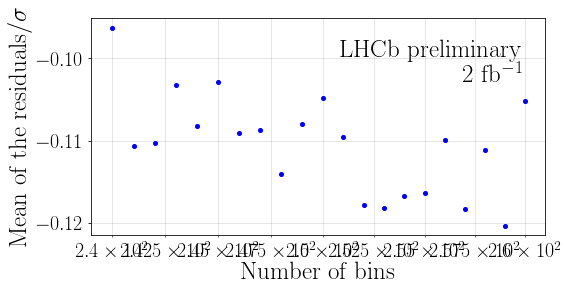

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/mean_residuals_vs_number_bins


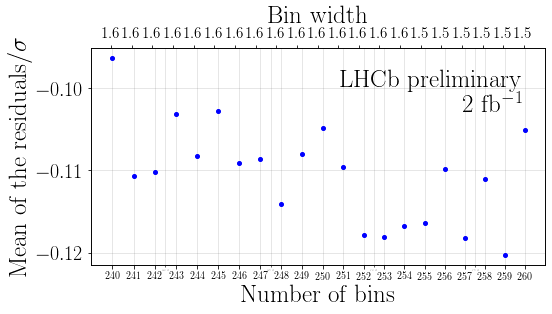

In [102]:
fig, ax = pl.plot_x_list_ys(l_n_bins, l_mean, 'Number of bins', 
               ['Mean of the residuals$/\sigma$'],
               name_folder=name_data, pos_text_LHC=[0.95, 0.9, 'right'],
                linestyle='', marker='o', markersize=4., log_scale='x',
                name_file='mean_residuals_vs_number_bins', save_fig=False)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
# ax2.set_xscale('log')

ax2.set_xticks(l_n_bins)
ax2.set_xticklabels(l_bin_width_around)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel("Bin width", fontsize=25)

ax.set_xticks(l_n_bins)
ax.set_xticklabels(l_n_bins, fontsize=10)
ax.tick_params(axis='x', which='minor', labelsize=0)

pt.save_file(fig, name_file='mean_residuals_vs_number_bins', name_folder=name_data)
fig

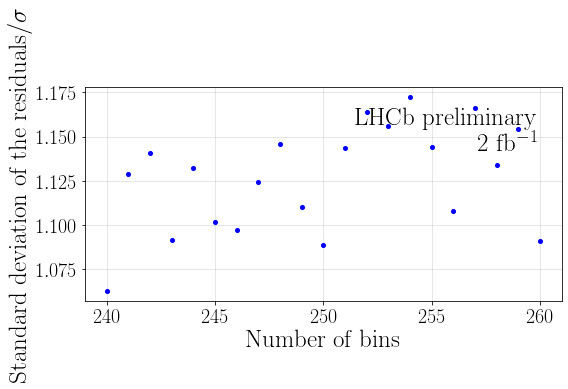

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/std_residuals_vs_number_bins


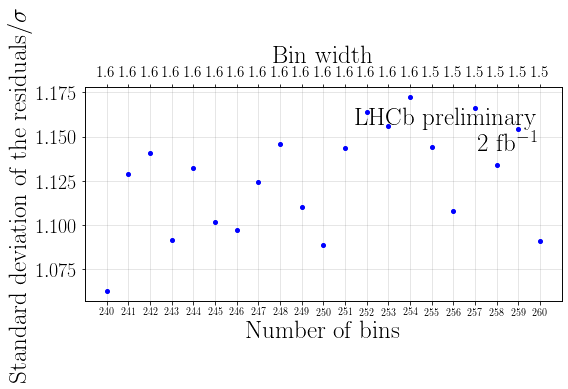

In [87]:
fig, ax = pl.plot_x_list_ys(l_n_bins, l_std, 'Number of bins', 
               ['Standard deviation of the residuals$/\sigma$'],
               name_folder=name_data, pos_text_LHC=[0.95, 0.9, 'right'],
                linestyle='', marker='o', markersize=4., #log_scale='x',
                name_file='std_residuals_vs_number_bins', save_fig=False)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
# ax2.set_xscale('log')

ax2.set_xticks(l_n_bins)
ax2.set_xticklabels(l_bin_width_around)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel("Bin width", fontsize=25)

ax.set_xticks(l_n_bins)
ax.set_xticklabels(l_n_bins)
ax.tick_params(axis='x', labelsize=10)

pt.save_file(fig, name_file='std_residuals_vs_number_bins', name_folder=name_data)
fig

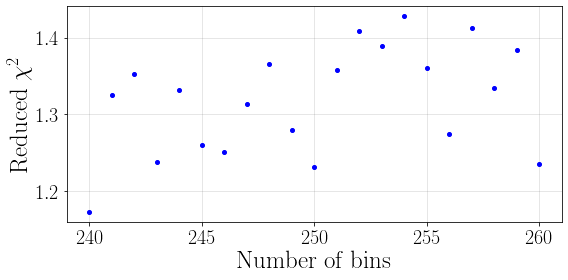

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/reduced_chi2_vs_number_bins


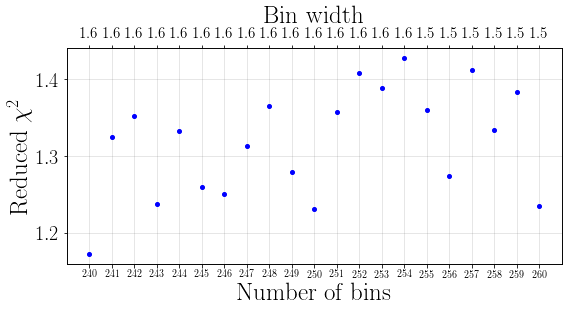

In [89]:
fig, ax = pl.plot_x_list_ys(l_n_bins, l_chi2, 'Number of bins', 
               ['Reduced $\\chi^2$'],
               name_folder=name_data, #pos_text_LHC=[0.95, 0.9, 'right'],
                linestyle='', marker='o', markersize=4., #log_scale='x',
                name_file='reduced_chi2_vs_number_bins', save_fig=False)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
# ax2.set_xscale('log')

ax2.set_xticks(l_n_bins)
ax2.set_xticklabels(l_bin_width_around)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel("Bin width", fontsize=25)

ax.set_xticks(l_n_bins)
ax.set_xticklabels(l_n_bins)
ax.tick_params(axis='x', labelsize=10)

pt.save_file(fig, name_file='reduced_chi2_vs_number_bins', name_folder=name_data)
fig

### Compare $B^0 \to D^* D_s$ and $B^0 \to D^* (D_s \to 3\pi)$
$$\mathcal{B}\left(B^0 \to D^{*-} D_s \right) = (8.0 \pm 1.1)\times 10^{-3}$$
$$\mathcal{B}\left(D_{s}^+ \to \pi^+ \pi^+ \pi^- \right) = (1.08 \pm 0.04)\times 10^{-2}$$

In [19]:
from uncertainties import ufloat

### $\frac{\mathcal{B}(B^0\to D^*D_s)}{\mathcal{B}(B^0\to D^*3\pi)}$, from the PDG

In [20]:
normal_mode_br = ufloat(7.21e-3, 0.29e-3)

In [21]:
bkgDs_br = ufloat(8.0e-3, 1.1e-3)*ufloat(1.08e-2, 0.04e-2)
print(bkgDs_br/normal_mode_br)
r_br_Ds = bkgDs_br/normal_mode_br

0.0120+/-0.0018


### $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$, from the fit

In [22]:
fitted_params_Ds = retrieve_params(name_data_B0toDstDs_BDT, name_folder=name_data_B0toDstDs)
n_bkgDs = ufloat(fitted_params_Ds['n_sig_DstDs|BDT-1.25'], fitted_params_Ds['n_sig_DstDs|BDT-1.25_err'])

In [23]:
n_normal_mode = ufloat(fitted_params['n_sig|BDT-1.25'],fitted_params['n_sig|BDT-1.25_err'])

In [24]:
r_bkgDs = n_bkgDs/n_normal_mode
print(r_bkgDs)

0.0264+/-0.0010


In [25]:
print(r_bkgDs/r_br_Ds)

2.20+/-0.34


## Compute the $_s$Weights

In [47]:
from hepstats import splot
import matplotlib.pyplot as plt

In [48]:
weights_hep = splot.compute_sweights(model, data)

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/hepstats/splot/sweights.py:129: AboveToleranceWarning: The Maximum Likelihood Sum Rule sanity check, described in equation 17 of arXiv:physics/0402083, failed. According to this check the following quantities
	* n_sig: 1.0002768368514505,
	* n_sig_Ds: 1.0005066803626073,
	* n_bkgK: 0.9919871291208787,
	* n_bkg: 0.9999911751555739,
should be equal to 1.0 with an absolute tolerance of 0.005. If the fit to the data is good please ignore this warning.
  warnings.warn(msg, AboveToleranceWarning)


In [49]:
weights_sig = weights_hep[zparams['n_sig']]
mass = df[var]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


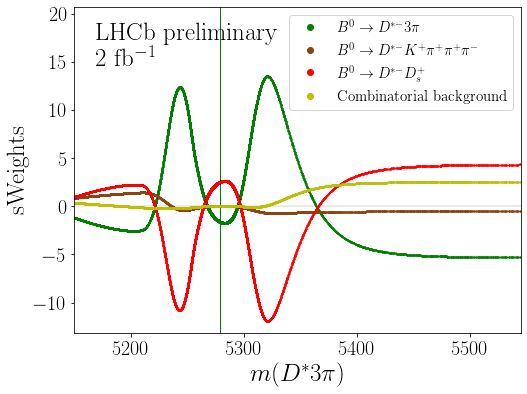

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr_BDT-1.25/sWeights


In [54]:
fig, ax = plt.subplots(figsize=(8,6))

ax.axhline(0, c='black', ls='-', alpha=0.1)
ax.axvline(x=float(zparams['mu']), color='green', linewidth=1.)

n = 5

ax.plot(mass, weights_hep[zparams['n_sig']],'.', label='$B^0 \\to D^{*-} 3\pi$', markersize=1., color='g')
ax.plot(mass, weights_hep[zparams['n_bkgK']],'.', label='$B^0 \\to D^{*-} K^+ \pi^+ \pi^+ \pi^-$', markersize=1., color='saddlebrown')
ax.plot(mass, weights_hep[zparams['n_sig_Ds']],'.', label='$B^0 \\to D^{*-} D_s^+$', markersize=1., color='r')
ax.plot(mass, weights_hep[zparams['n_bkg']],'.', label='Combinatorial background', markersize=1., color='y')

ax.set_xlim(low, high) 

ax.set_xlabel('$m(D^* 3\pi)$',fontsize=25)
ax.set_ylabel('sWeights',fontsize=25)

ymin, ymax = ax.get_ylim()
#ax.set_ylim(ymin, ymax*1.1)
pt.fix_plot(ax, ymax=1.4, pos_text_LHC=[0.05, 0.95, 'left'], ymin_to0=False)
ax.legend(markerscale=12, fontsize=15)


plt.show()
plt.close()

pt.save_file(fig, 'sWeights', name_folder=name_data_BDT)